In [1]:
!which python; python --version; pwd

/Users/swagatam/miniconda3/envs/sbi/bin/python
Python 3.10.14
/Users/swagatam/Desktop/ws24/sbi/sourcerer-sequential/results_analysis


In [2]:
import os
from time import time_ns; from datetime import datetime
import numpy as np; import pandas as pd; import matplotlib.pyplot as plt
import torch
from corner import corner
from omegaconf import OmegaConf as OC

In [3]:
import matplotlib
# matplotlib.rcParams['lines.linewidth'] = 2
matplotlib.rcParams['font.family'] = "sans-serif"
# matplotlib.rcParams['legend.fontsize'] = 15
# matplotlib.rcParams['axes.labelsize'] = 15
# matplotlib.rcParams['xtick.labelsize'] = 15
# matplotlib.rcParams['ytick.labelsize'] = 15
# matplotlib.rcParams['legend.title_fontsize'] = 15
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['axes.spines.right'] = False
# matplotlib.rcParams['figure.dpi'] = 250
# matplotlib.rcParams['figure.figsize'] = (4,3)
# cmap = plt.get_cmap("viridis")

this notebook has baseline and data aggregation results:
- with fixed lambda, no aggregation of training data over iterations
- if keeping data from previous iterations helps (aggregate data)

In [4]:
base_path_baseline = '../results_sequential_naive_baseline/'
base_path_aggregate = '../results_sequential_naive_aggrdata/'
foldertxt = "seq_{S}_{B}_{I}_{SEED}"
filetxt = 'run_{B}_{I}_{SEED}_results_df.csv'

In [5]:
SIMULATORS = ["gaussian_mixture", "inverse_kinematics", "two_moons", "slcp"]
SEEDS = {
    "gaussian_mixture": [34358, 12235, 9656, 3828, 54973],
    "inverse_kinematics": [34358, 12235, 9656, 3828, 54973],
    "two_moons": [50134, 12235, 9656, 3828, 54973],
    "slcp": [20367, 12235, 9656, 3828, 54973]
}
METRICS_NAMES = ['surro_c2sts',
                 'source_simu_pf_c2sts',
                 'source_surro_pf_c2sts',
                 "source_simu_pf_swds",
                 'source_entropies'
                ]
METRICS_LABELS = {
    "surro_c2sts": "Surrogate C2ST",
    "source_simu_pf_swds": "Source SWD (PF using sim.)",
    "source_simu_pf_c2sts": "Source C2ST\n(PF using sim.)",
    "source_surro_pf_c2sts": "Source C2ST\n(PF using surr.)",
    "source_entropies": "Source entropy estimate",
}

In [6]:
np.genfromtxt('../results_sequential_naive_aggrdata/seq_slcp_12000_10_20367/run_12000_10_20367_expected_swd.csv')

array(0.17703132)

In [7]:
# mean_gt_swd(base_path_baseline, 'slcp', 1000, 4)

In [8]:
def path_to_csv(base_path, sim, budget, iters, seed):
    return os.path.join(base_path,
                        foldertxt.format(S=sim, B=budget, I=iters, SEED=seed),
                        filetxt.format(B=budget, I=iters, SEED=seed)
                       )
def average_df_over_seeds(base_path, sim, budget, iters):
    dflist = []
    columns = pd.read_csv(path_to_csv(base_path, sim, budget, iters, SEEDS[sim][0])).columns # just fetch column names
    for seed in SEEDS[sim]:
        path = path_to_csv(base_path, sim, budget, iters, seed)
        if os.path.exists(path):
            dflist.append(
                pd.read_csv(path)
            )
        else:
            print(f"Could not find file: {path}")
    # assert len(dflist) == len(SEEDS[sim])
    mean_df = pd.DataFrame(np.stack(dflist, axis=0).mean(0), columns=columns)
    std_df = pd.DataFrame(np.stack(dflist, axis=0).std(0), columns=columns)
    return mean_df, std_df

def gt_source_kole(base_path, sim, budget, iters, seed):
    path_to_array = os.path.join(base_path,
                                 foldertxt.format(S=sim, B=budget, I=iters, SEED=seed),
                                 f"run_{budget}_{iters}_{seed}_gt_source_kole.csv"
                                )
    # print(path_to_array)
    return np.genfromtxt(path_to_array)

def mean_gt_source_kole(base_path, sim, budget, iters):
    arrays = []
    for seed in SEEDS[sim]:
        arrays.append(
            gt_source_kole(base_path, sim, budget, iters, seed)
        )
    # print(arrays)
    return np.array(arrays).mean()

def gt_swd(base_path, sim, budget, iters, seed):
    # print(sim, budget, iters, seed)
    path_to_array = os.path.join(base_path,
                                 foldertxt.format(S=sim, B=budget, I=iters, SEED=seed),
                                 f"run_{budget}_{iters}_{seed}_expected_swd.csv"
                                )
    # print(path_to_array)
    return np.genfromtxt(path_to_array)


def mean_gt_swd(base_path, sim, budget, iters):
    arrays = []
    for seed in SEEDS[sim]:
        arrays.append(
            gt_swd(base_path, sim, budget, iters, seed)
        )
    # print(arrays)
    return np.array(arrays).mean()


def fetch_losses(base_path, sim, budget, iters, seed):
    train_losses_path = os.path.join(base_path,
                                     foldertxt.format(S=sim, B=budget, I=iters, SEED=seed),
                                     f"run_{budget}_{iters}_{seed}_train_losses_surro.csv"
                                    )
    val_losses_path = os.path.join(base_path,
                                     foldertxt.format(S=sim, B=budget, I=iters, SEED=seed),
                                     f"run_{budget}_{iters}_{seed}_val_losses_surro.csv"
                                    )
    train_losses_source_path = os.path.join(base_path,
                                     foldertxt.format(S=sim, B=budget, I=iters, SEED=seed),
                                     f"run_{budget}_{iters}_{seed}_source_training_losses.csv"
                                    )
    train_losses = np.genfromtxt(train_losses_path)
    val_losses = np.genfromtxt(val_losses_path)
    train_losses_source = np.genfromtxt(train_losses_source_path)
    
    return train_losses, val_losses, train_losses_source


def loss_plots(base_path, sim, budget, iters, seed, start_idx=100):
    train, val, src_train = fetch_losses(base_path, sim, budget, iters, seed)

    title = f"{sim}\nb={budget}, its={iters}"
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5*2, 3*1), gridspec_kw={'wspace':0.2,'hspace':0.5})
    
    axes[0].plot(train[start_idx:], label=f"surro. train loss")
    axes[0].plot(val[start_idx:], label=f"surro. val. loss")
    axes[0].set_xlabel("epochs")
    axes[0].legend(fontsize=6, title=title, title_fontsize=7)
    axes[1].plot(src_train, label=f"source training loss"); 
    axes[1].set_xlabel("epochs")
    # axes[1].set_yscale('log')
    axes[1].legend(fontsize=6, title=title, title_fontsize=7)
    
    return fig

In [9]:
simulator = "inverse_kinematics"
b=15000
it=5
seed = SEEDS[simulator][0]
seed

34358

In [10]:
pd.read_csv(path_to_csv(base_path_aggregate, simulator, b, it, SEEDS[simulator][2]))

,budgets,surro_c2sts,surro_swds,source_simu_pf_swds,source_simu_pf_c2sts,source_surro_pf_c2sts,source_c2sts,source_entropies
0,3000,0.70315,0.200758,0.066134,0.65200,0.65540,0.92735,3.666640
1,3000,0.52650,0.029427,0.022772,0.51245,0.52030,0.86440,3.784482
2,3000,0.48065,0.008257,0.019189,0.49810,0.50415,0.85330,3.792611
3,3000,0.47260,0.005962,0.022417,0.49790,0.50555,0.85420,3.851130
4,3000,0.46835,0.006093,0.025086,0.49630,0.50635,0.85275,3.912458


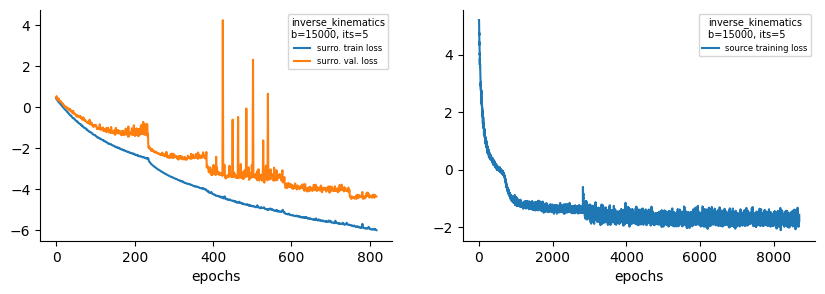

In [11]:
loss_plots(base_path_aggregate, simulator, b, it, SEEDS[simulator][2])
plt.show()

In [12]:
average_df_over_seeds(base_path_baseline, simulator, b, it)[0]

,budgets,surro_c2sts,surro_swds,source_simu_pf_swds,source_simu_pf_c2sts,source_surro_pf_c2sts,source_c2sts,source_entropies
0,3000.0,0.67862,0.188140,0.058417,0.63537,0.63105,0.92387,3.668719
1,3000.0,0.53019,0.041986,0.026185,0.52725,0.53255,0.86949,3.772140
2,3000.0,0.49363,0.024446,0.025288,0.50736,0.51019,0.85308,3.790085
3,3000.0,0.48156,0.022841,0.026771,0.50943,0.51316,0.85032,3.822999
4,3000.0,0.47566,0.018552,0.022347,0.50274,0.50700,0.85142,3.834508


In [13]:
average_df_over_seeds(base_path_aggregate, simulator, b, it)[0]

,budgets,surro_c2sts,surro_swds,source_simu_pf_swds,source_simu_pf_c2sts,source_surro_pf_c2sts,source_c2sts,source_entropies
0,3000.0,0.67862,0.188140,0.058417,0.63537,0.63105,0.92387,3.668719
1,3000.0,0.53449,0.038335,0.028814,0.52606,0.53198,0.86806,3.750849
2,3000.0,0.48860,0.011655,0.024780,0.50514,0.50604,0.85273,3.766548
3,3000.0,0.47804,0.009067,0.026037,0.50335,0.50627,0.85218,3.819231
4,3000.0,0.46934,0.008037,0.023565,0.50245,0.50632,0.85273,3.852311


In [14]:
average_df_over_seeds(base_path_aggregate, simulator, b, it)[1]

,budgets,surro_c2sts,surro_swds,source_simu_pf_swds,source_simu_pf_c2sts,source_surro_pf_c2sts,source_c2sts,source_entropies
0,0.0,0.066845,0.084086,0.019584,0.041288,0.050051,0.026305,0.040264
1,0.0,0.024902,0.010998,0.007170,0.013612,0.018114,0.011716,0.024692
2,0.0,0.006420,0.002658,0.007253,0.004406,0.004472,0.007386,0.059583
3,0.0,0.003439,0.001831,0.003972,0.003199,0.001768,0.005716,0.050924
4,0.0,0.004297,0.001537,0.002428,0.003728,0.004637,0.004609,0.059538


In [15]:
BUDGETS = [1000, 2000, 3000, 4000, 5000, 6000, 8000, 12_000, 15_000]
ITERS = [1, 2, 3, 4, 5, 6, 8, 10]

In [16]:
def plot_metrics(simulator, base_path):
    rows, nrows = BUDGETS, len(BUDGETS)
    ncols = len(METRICS_NAMES)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4.5*nrows), gridspec_kw={'wspace':0.2,'hspace':0.5})

    gt_ent, gt_wasser = None, None
    for loci, b in enumerate(rows):
        gt_entropy = mean_gt_source_kole(base_path, simulator, b, 1)
        gt_wasser = mean_gt_swd(base_path, simulator, b, 1)
        
        vals = np.zeros((len(ITERS), len(METRICS_NAMES)))
        stds = np.zeros((len(ITERS), len(METRICS_NAMES)))
        for i, num_iters in enumerate(ITERS):
            mean_df, std_df = average_df_over_seeds(base_path, simulator, b, num_iters)
            mean_df = mean_df[METRICS_NAMES].iloc[-1:]
            std_df = std_df[METRICS_NAMES].iloc[-1:]
            vals[i], stds[i] = mean_df.values, std_df.values

        for locj in range(ncols):
            ax = axes[loci, locj]
            ax.errorbar(x=ITERS, y=vals[:, locj], yerr=stds[:, locj], capsize=1.5, elinewidth=2, fmt='o', linestyle='-')#, label="Direct DT")
            # ax.plot(iters, vals[:, locj], 'o-')
            if locj!=ncols-1:
                ax.set_ylim(0.45, 0.9)
                ax.axhline(0.5, color='g', ls=':')
            else:
                ax.axhline(gt_entropy, color='k', ls=':', label='gt kole')
                # ax.axhline(gt_swds, color='r', ls=':', label='gt swd')
                ax.legend()

            ax.set_title(f"{simulator}, B: {b}")
            ax.set_xlabel("# iterations")
            ax.set_ylabel(METRICS_NAMES[locj])

    return fig

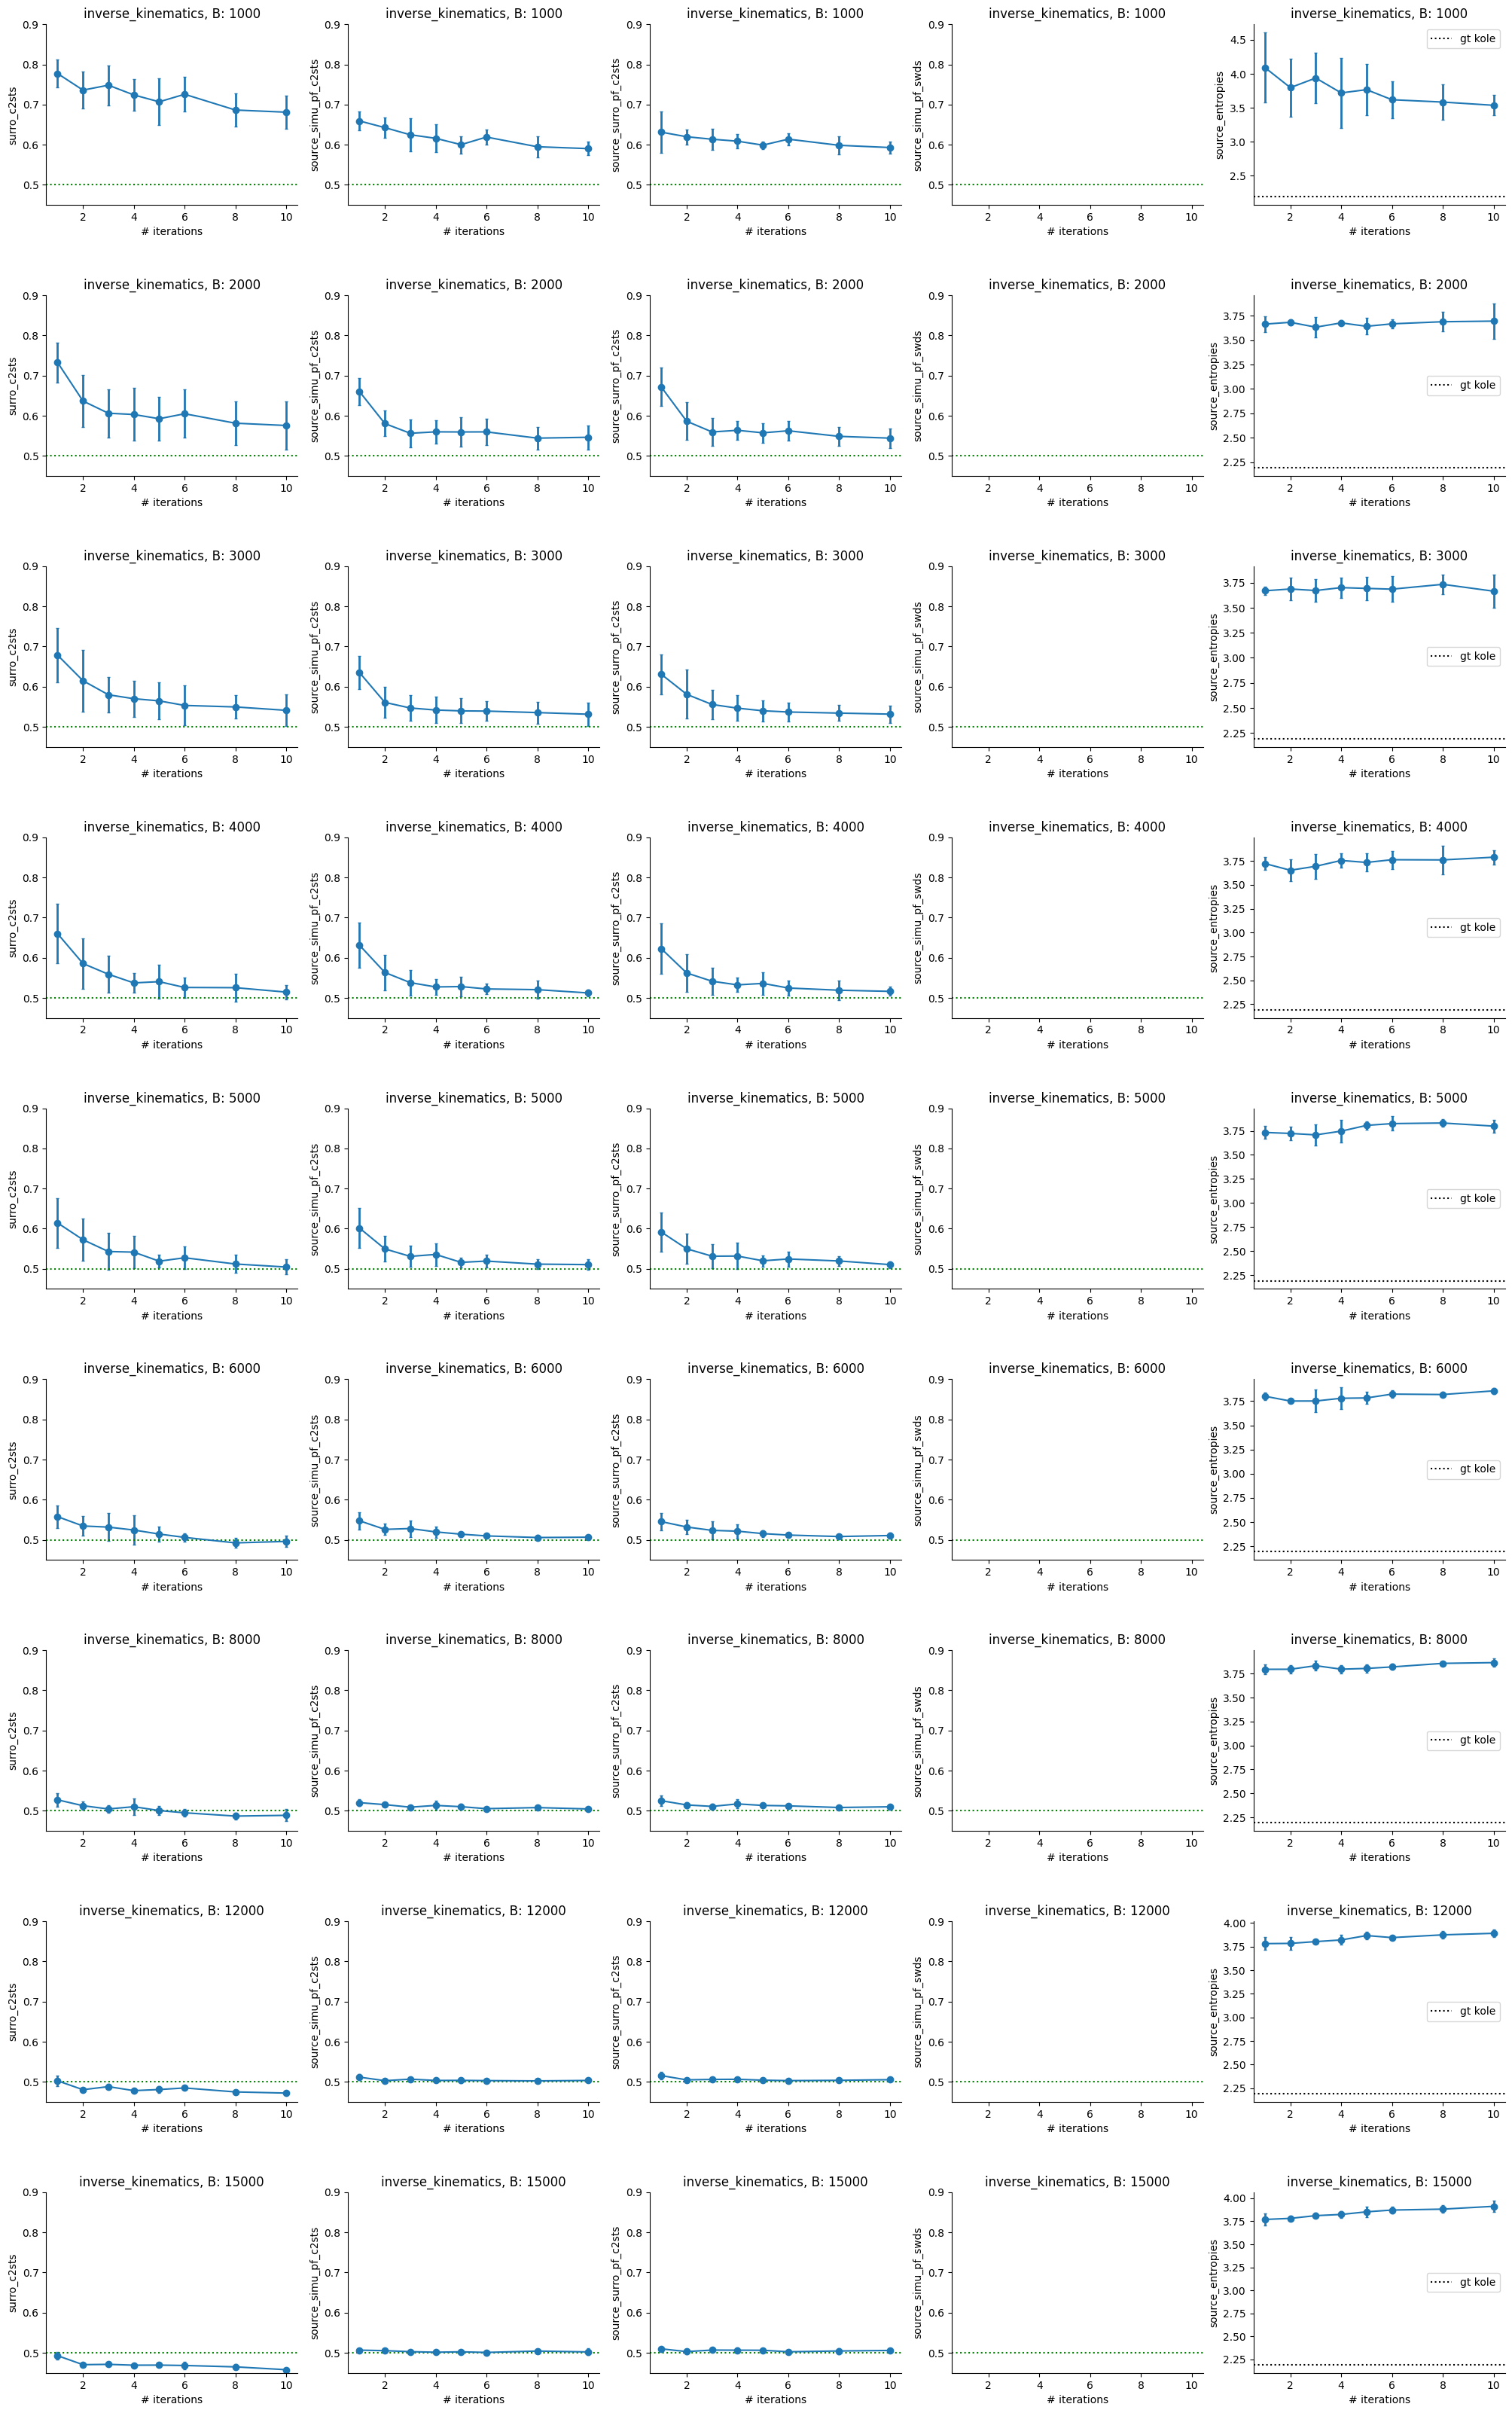

In [17]:
plot_metrics(simulator='inverse_kinematics', base_path=base_path_aggregate)
plt.show()

In [18]:
# plot_metrics(simulator='slcp', base_path=base_path_baseline)
# plt.show()

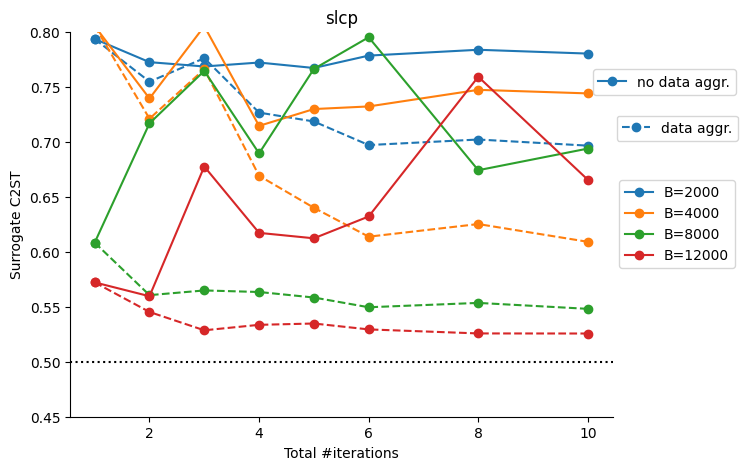

In [19]:
fig, ax = plt.subplots(figsize=(7, 5))

simulator='slcp'
metric_idx = 0

plt_baselines = []
plt_aggregates = []
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for bidx, b in enumerate([2000, 4000, 8000, 12_000]):
    vals = np.zeros((len(ITERS), len(METRICS_NAMES)))
    stds = np.zeros((len(ITERS), len(METRICS_NAMES)))
    for i, num_iters in enumerate(ITERS):
        mean_df, std_df = average_df_over_seeds(base_path_baseline,
                                                simulator, b, num_iters)
        mean_df = mean_df[METRICS_NAMES].iloc[-1:]
        std_df = std_df[METRICS_NAMES].iloc[-1:]
        vals[i], stds[i] = mean_df.values, std_df.values

    
    # ax.errorbar(x=ITERS, y=vals[:, metric_idx], yerr=stds[:, metric_idx],
                # capsize=1.5, elinewidth=2, fmt='o', linestyle='-', label=f"B={b}")
    p1, = ax.plot(ITERS, vals[:, metric_idx], 'o-', color=colors[bidx], label=f"B={b}")
    plt_baselines.append(p1)
    
    vals = np.zeros((len(ITERS), len(METRICS_NAMES)))
    stds = np.zeros((len(ITERS), len(METRICS_NAMES)))
    for i, num_iters in enumerate(ITERS):
        mean_df, std_df = average_df_over_seeds(base_path_aggregate,
                                                simulator, b, num_iters)
        mean_df = mean_df[METRICS_NAMES].iloc[-1:]
        std_df = std_df[METRICS_NAMES].iloc[-1:]
        vals[i], stds[i] = mean_df.values, std_df.values

    
    # ax.errorbar(x=ITERS, y=vals[:, metric_idx], yerr=stds[:, metric_idx],
                # capsize=1.5, elinewidth=2, fmt='o', linestyle='-', label=f"B={b}")
    p2, = ax.plot(ITERS, vals[:, metric_idx], 'o--',color=colors[bidx])
    plt_aggregates.append(p2)



leg1 = plt.legend(plt_baselines[0:1], ['no data aggr.'], loc='upper right', bbox_to_anchor=(1.24, 0.92))
leg2 = plt.legend(plt_aggregates[0:1], ["data aggr."], loc='upper right', bbox_to_anchor=(1.244, 0.8))
ax.add_artist(leg1); ax.add_artist(leg2)


ax.set_ylim(0.45, 0.8)
ax.axhline(0.5, color='k', ls=':')

ax.set_title(f"{simulator}")
ax.set_xlabel("Total #iterations")
ax.set_ylabel(METRICS_LABELS[METRICS_NAMES[metric_idx]])    

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [20]:
mean_gt_source_kole(base_path_aggregate, simulator, 15000, 2)

9.170836001361158

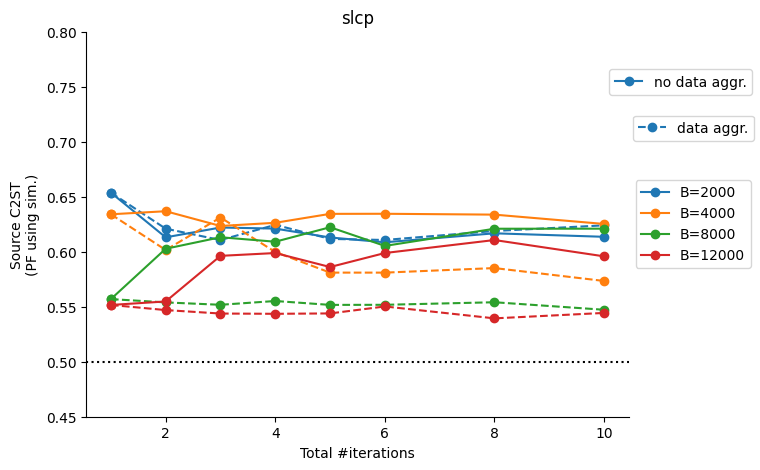

In [26]:
fig, ax = plt.subplots(figsize=(7, 5))

simulator='slcp'
metric_idx = 1

plt_baselines = []
plt_aggregates = []
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for bidx, b in enumerate([2000, 4000, 8000, 12_000]):
    vals = np.zeros((len(ITERS), len(METRICS_NAMES)))
    stds = np.zeros((len(ITERS), len(METRICS_NAMES)))
    for i, num_iters in enumerate(ITERS):
        mean_df, std_df = average_df_over_seeds(base_path_baseline,
                                                simulator, b, num_iters)
        mean_df = mean_df[METRICS_NAMES].iloc[-1:]
        std_df = std_df[METRICS_NAMES].iloc[-1:]
        vals[i], stds[i] = mean_df.values, std_df.values

    
    # ax.errorbar(x=ITERS, y=vals[:, metric_idx], yerr=stds[:, metric_idx],
                # capsize=1.5, elinewidth=2, fmt='o', linestyle='-', label=f"B={b}")
    p1, = ax.plot(ITERS, vals[:, metric_idx], 'o-', color=colors[bidx], label=f"B={b}")
    plt_baselines.append(p1)
    
    vals = np.zeros((len(ITERS), len(METRICS_NAMES)))
    stds = np.zeros((len(ITERS), len(METRICS_NAMES)))
    for i, num_iters in enumerate(ITERS):
        mean_df, std_df = average_df_over_seeds(base_path_aggregate,
                                                simulator, b, num_iters)
        mean_df = mean_df[METRICS_NAMES].iloc[-1:]
        std_df = std_df[METRICS_NAMES].iloc[-1:]
        vals[i], stds[i] = mean_df.values, std_df.values

    
    # ax.errorbar(x=ITERS, y=vals[:, metric_idx], yerr=stds[:, metric_idx],
                # capsize=1.5, elinewidth=2, fmt='o', linestyle='-', label=f"B={b}")
    p2, = ax.plot(ITERS, vals[:, metric_idx], 'o--',color=colors[bidx])
    plt_aggregates.append(p2)



leg1 = plt.legend(plt_baselines[0:1], ['no data aggr.'], loc='upper right', bbox_to_anchor=(1.24, 0.92))
leg2 = plt.legend(plt_aggregates[0:1], ["data aggr."], loc='upper right', bbox_to_anchor=(1.244, 0.8))
ax.add_artist(leg1); ax.add_artist(leg2)


ax.set_ylim(0.45, 0.8)
ax.axhline(0.5, color='k', ls=':')

ax.set_title(f"{simulator}")
ax.set_xlabel("Total #iterations")
ax.set_ylabel(METRICS_LABELS[METRICS_NAMES[metric_idx]])    

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [21]:
def plot_metric_multiple_budgets(base_path, simulator, metric_idx,
                                 budgets=[1000, 2000, 3000, 6000, 8000, 15_000],
                                 error_bars=False,
                                 legend=True,
                                 ax=None
                                ):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    for bidx, b in enumerate(budgets):
        vals = np.zeros((len(ITERS), len(METRICS_NAMES)))
        stds = np.zeros((len(ITERS), len(METRICS_NAMES)))
        for i, num_iters in enumerate(ITERS):
            mean_df, std_df = average_df_over_seeds(base_path, simulator, b, num_iters)
            mean_df, std_df = mean_df[METRICS_NAMES].iloc[-1:], std_df[METRICS_NAMES].iloc[-1:]
            vals[i], stds[i] = mean_df.values, std_df.values
        if error_bars:
            ax.errorbar(x=ITERS, y=vals[:, metric_idx], yerr=stds[:, metric_idx], capsize=1.5, elinewidth=2, fmt='o', linestyle='-', label=f"B={b:,}")
        else:
            ax.plot(ITERS, vals[:, metric_idx], 'o-', color=colors[bidx], label=f"B={b:,}")

    if METRICS_NAMES[metric_idx] in ['surro_c2sts', 'source_simu_pf_c2sts', 'source_surro_pf_c2sts']:
        ax.axhline(0.5, color='k', ls=':')
        ax.set_ylim(0.45, 0.85)
    if METRICS_NAMES[metric_idx] == 'source_simu_pf_swds':
        ax.axhline(mean_gt_swd(base_path, simulator, 15000, 1), color='k', ls='--', label='baseline swd') # any budget/iter work here
        handles, _ = ax.get_legend_handles_labels()
        # Slice list to remove budgets
        ax.legend(handles = handles[-1:])
    if METRICS_NAMES[metric_idx] == 'source_entropies':
        ax.axhline(mean_gt_source_kole(base_path, simulator, 15000, 1), color='r', ls='--', label='gt kole') # any budget/iter work here
    
    ax.set_title(f"simulator: {simulator}")
    ax.set_xlabel("Total #iterations")
    ax.set_ylabel(METRICS_LABELS[METRICS_NAMES[metric_idx]])    
    if legend:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # return ax

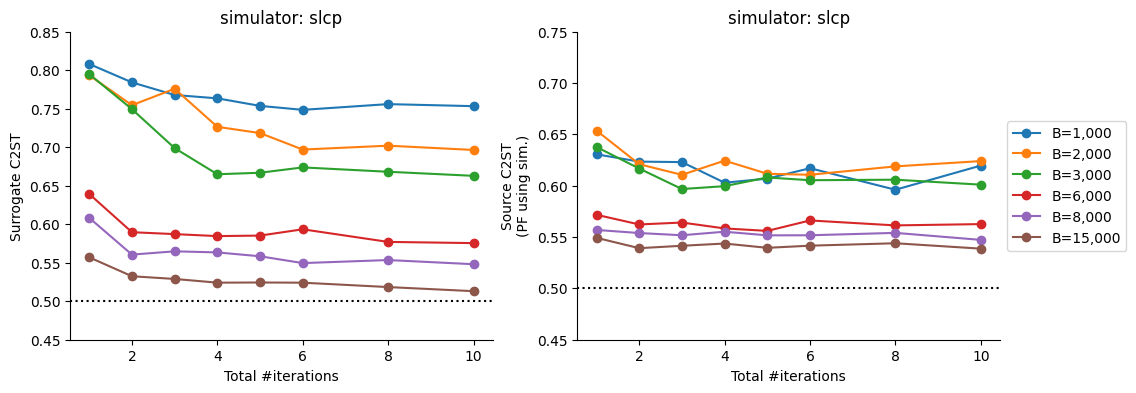

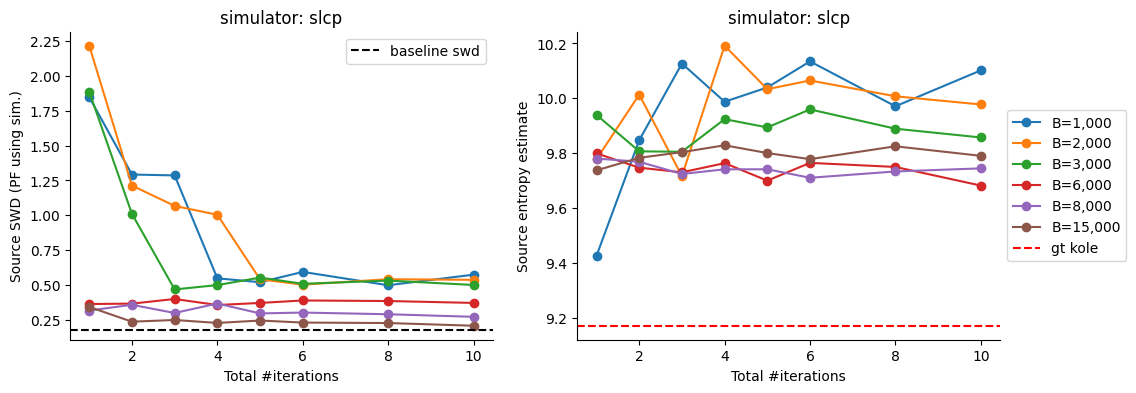

In [22]:
simulator='slcp'
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 4*1), gridspec_kw={'wspace':0.2,'hspace':0.5})
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=0, ax=axes[0], legend=False)
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=1, ax=axes[1], legend=True)
axes[1].set_ylim(0.45, 0.75)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 4*1), gridspec_kw={'wspace':0.2,'hspace':0.5})
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=3, ax=axes[0], legend=False)
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=4, ax=axes[1], legend=True)

plt.show()

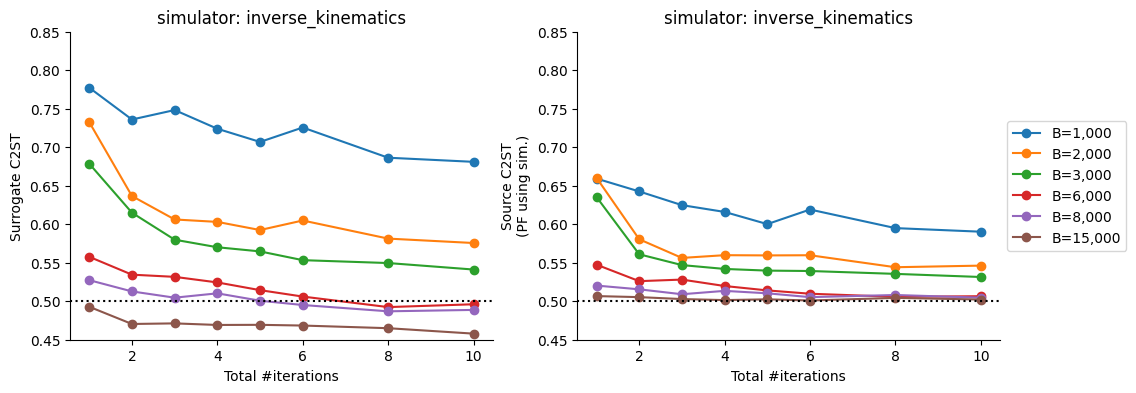

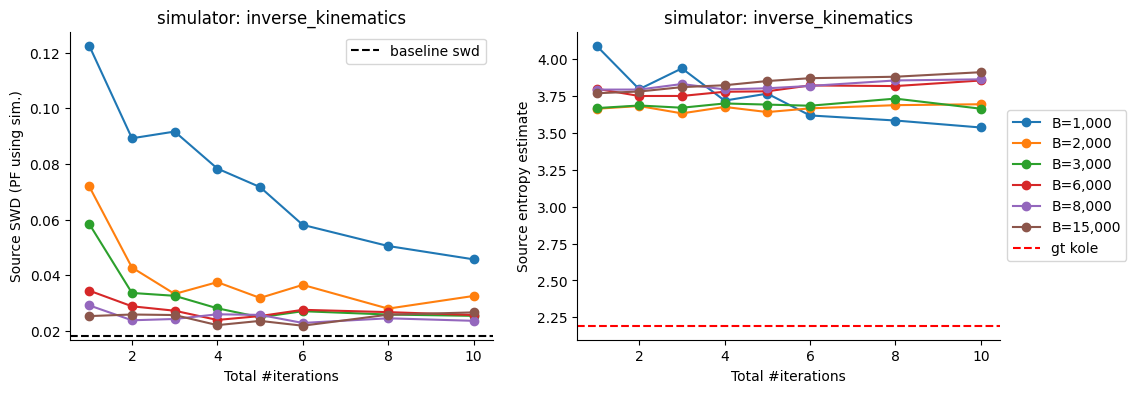

In [23]:
simulator='inverse_kinematics'
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 4*1), gridspec_kw={'wspace':0.2,'hspace':0.5})
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=0, ax=axes[0], legend=False)
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=1, ax=axes[1], legend=True)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 4*1), gridspec_kw={'wspace':0.2,'hspace':0.5})
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=3, ax=axes[0], legend=False)
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=4, ax=axes[1], legend=True)

plt.show()

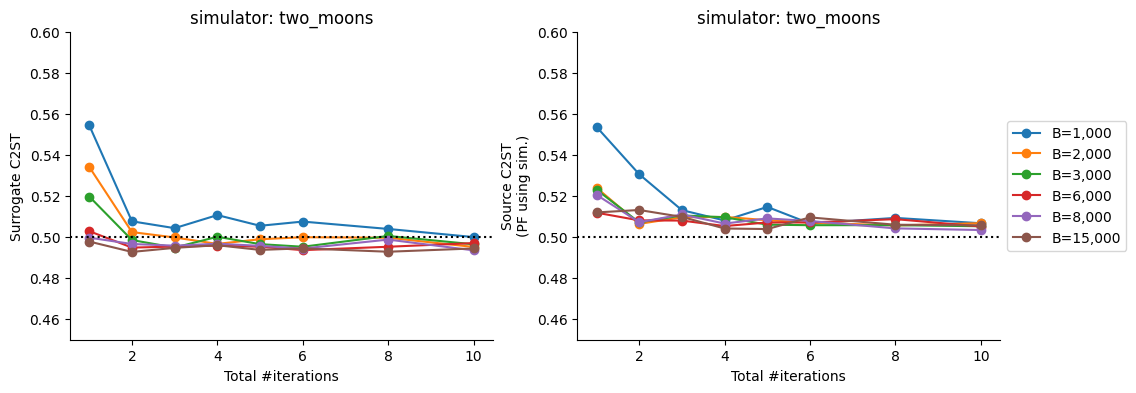

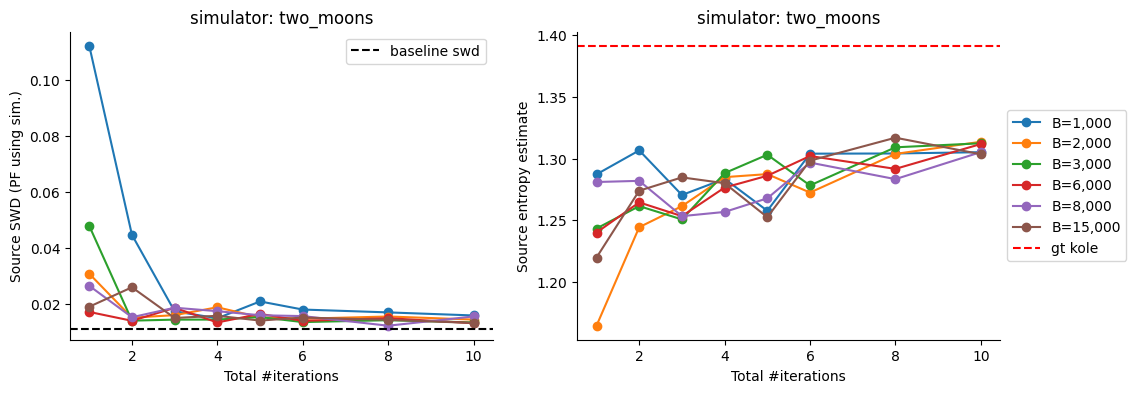

In [24]:
simulator='two_moons'
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 4*1), gridspec_kw={'wspace':0.2,'hspace':0.5})
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=0, ax=axes[0], legend=False)
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=1, ax=axes[1], legend=True)
axes[0].set_ylim(0.45, 0.6); axes[1].set_ylim(0.45, 0.6)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 4*1), gridspec_kw={'wspace':0.2,'hspace':0.5})
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=3, ax=axes[0], legend=False)
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=4, ax=axes[1], legend=True)

plt.show()

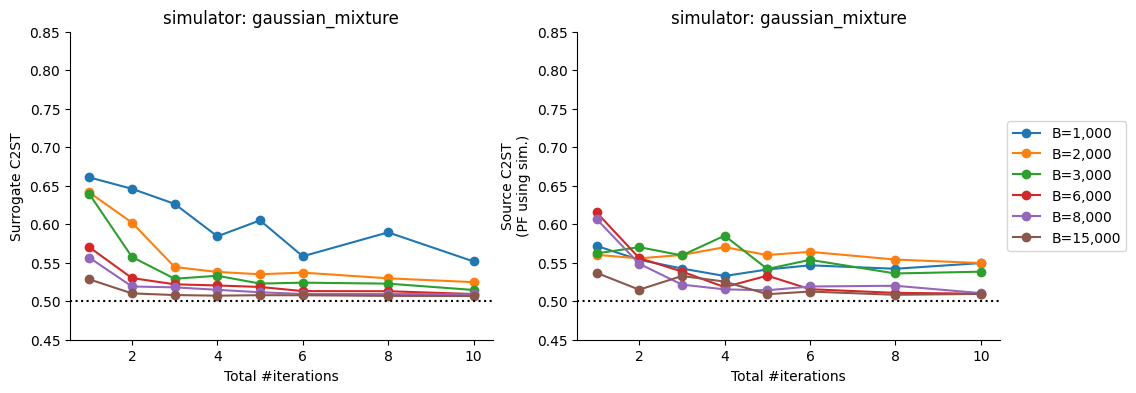

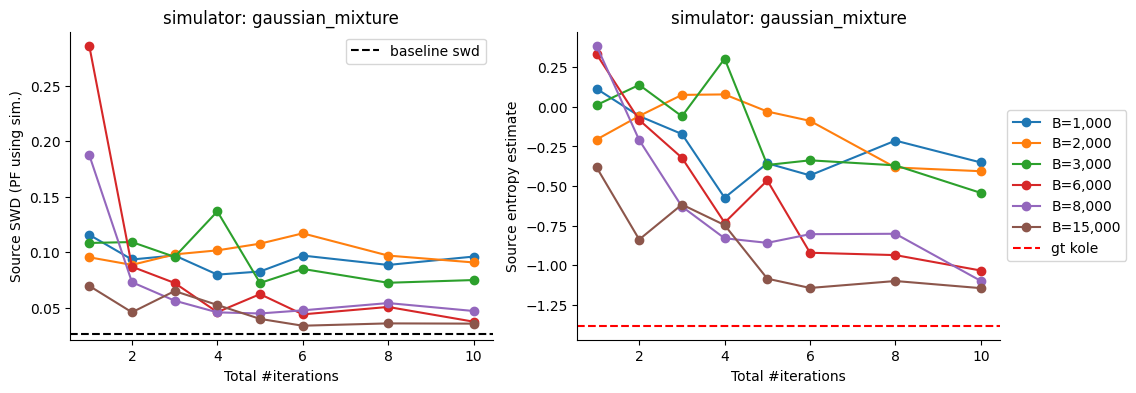

In [25]:
simulator='gaussian_mixture'
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 4*1), gridspec_kw={'wspace':0.2,'hspace':0.5})
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=0, ax=axes[0], legend=False)
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=1, ax=axes[1], legend=True)
# axes[0].set_ylim(0.45, 0.7); axes[1].set_ylim(0.45, 0.7)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6*2, 4*1), gridspec_kw={'wspace':0.2,'hspace':0.5})
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=3, ax=axes[0], legend=False)
plot_metric_multiple_budgets(base_path_aggregate, simulator, metric_idx=4, ax=axes[1], legend=True)

plt.show()

## meeting notes 27.11.24:

1. active source estimation
- problem with the ASNPE paper, if you have N=1M, and B=1000 --> would you not sample the same "good" examples again and again? duplicates issue
- active source estimation vs. active snpe-c/sbi: also in source estimation we have many x-s --> uncertainty kind of averages out. unlike sbi, where we just want to focus on a single observation $x_o$
- 


2. ensemble of surrogates or bayesian neural networks surrogate
- we have fitted a source, now we need to sample new theta-s
- now where can we sample thetas to have the greatest impact on improving the surrogate?
- we sample x ~ p(x|θ) from the simulator to update the surrogate, which x-s would be more informative to train the surrogate?
- the θ-s which can possibly generate a greater variety of x-s => p(x|θ) is a high variance (?) distribution -- how do we identify such θ-s?
- need to design a proposal distribution (to sample θ-s instead of directly sampling from the source) which takes into account the source estimated so far, and the surrogate _uncertainty_, and then generates the θ-s to simulate observations from
- Thus the dataset to update the surrogate should contain θ-s where the simulator is more uncertain?


3. read the paper: Learning Diffusion Priors from Observations by Expectation Maximization
- useful for high dimensional problems? how?
- nice excuse to start learning about diffusion models I guess
- for masters thesis, need send an email to mls-jobs

3. hodgkin-huxley experiments:
- once we have some results, I can start writing the report --- from research project perspective should be enough?
- some workshop paper out of it?